<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# OpenScale Tutorial, PyTorch Image MultiClass Model on WML Function

This notebook includes steps for creating an image-based watson-machine-learning model, creating a subscription, configuring explainability, and finally generating an explanation for a transaction.

### Contents
- [1. Setup](#setup)
- [2. Creating and deploying an image-based model](#deployment)
- [3. Subscriptions](#subscription)
- [4. Explainability](#explainability)

**Note**: This notebook is using runtime 'Default Python 3.7.x'

<a id="setup"></a>
## 1. Setup

### 1.1 Install Watson OpenScale and WML packages

In [1]:
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1

In [2]:
!pip install --upgrade ibm-watson-machine-learning --no-cache | tail -n 1

Note: Restart the kernel to assure the new libraries are being used.

### 1.2 Configure credentials

In [3]:
import os
WML_CREDENTIALS = {
    'url':os.environ['RUNTIME_ENV_APSX_URL'],
    'token':os.environ['USER_ACCESS_TOKEN'],
    'instance_id':'openshift',
    'version':'4.0'}

<a id="deployment"></a>
## 2. Creating and deploying an image-based model

The dataset used is MNIST dataset of handwritten digits. It consists of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More information about the dataset can be found here: https://keras.io/datasets/#mnist-database-of-handwritten-digits

Note: Keras and TensorFlow versions supported by WML are: Keras 2.1.6 with TensorFlow 1.13 backend and Keras 2.2.4 with TensorFlow 1.14 backend. The latter combination is used in this notebook.

### 2.1 Creating a model

In [4]:
import numpy as np
import torch
import os


# load model definition
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64 * 7 * 7, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = out.view(out.size(0), -1)
        out = out.flatten(start_dim = 1)
        logits = self.layer3(out)
        out = F.softmax(logits, dim=1)
        return out


In [5]:
from torch import load as ptload

device = torch.device("cpu")
model = MyModel()

model_weights = torch.load('/mnts/deepliif-data/pytorch-toy-model/mnist.pt')
model.load_state_dict(model_weights)

model.to(device)
model.eval()

MyModel(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=3136, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [8]:
x = ptload('./MNIST/processed/test.pt')[0][0:1000,:,:]
x.shape

torch.Size([1000, 28, 28])

### 2.2 Creating Python Function

In [166]:
ai_parms = {
            "RUNTIME_ENV_APSX_URL":os.environ['RUNTIME_ENV_APSX_URL'],
            "USER_ACCESS_TOKEN": os.environ['USER_ACCESS_TOKEN'],
            "path_model": 'pytorch-toy-model/mnist.pt'
           }

def deployable_function(parms=ai_parms):
    
    import numpy as np
    import os
    import torch
    
    # load model definition
    import torch.nn as nn
    import torch.nn.functional as F

    class MyModel(nn.Module):
        def __init__(self):
            super(MyModel, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.layer2 = nn.Sequential(
                nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.layer3 = nn.Sequential(
                nn.Linear(64 * 7 * 7, 64),
                nn.ReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(64, 10)
            )

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            #out = out.view(out.size(0), -1)
            out = out.flatten(start_dim = 1)
            logits = self.layer3(out)
            out = F.softmax(logits, dim=1)
            return out

    
    # load model weights
    import urllib
    import requests
    
    USER_ACCESS_TOKEN = parms['USER_ACCESS_TOKEN']
    BASE_URL = parms['RUNTIME_ENV_APSX_URL']
    volume_display_name = 'DeepLiif-Data'

    path_model_encoded = urllib.parse.quote(parms['path_model'],safe='')
    url = f'/zen-volumes/{volume_display_name}/v1/volumes/files/{path_model_encoded}'
    res = requests.get(url=BASE_URL+url,
                       headers={'Authorization': 'Bearer ' + USER_ACCESS_TOKEN},
                       verify=False)
    
    path_model_local = parms['path_model'].split('/')[-1]
    with open(path_model_local,'wb') as f:
        f.write(res.content)
    
    model_weights = torch.load(path_model_local)
    
    
    # load model
    device = torch.device("cpu")
    model = MyModel()
    model.load_state_dict(model_weights)
    model.to(device)
    model.eval()
    
    def format_output(pred_raw):
        res = {"predictions":[{"id": "dense_1",
                               "fields": ["prediction","prediction_classes","probability"],
                               "values": []
                              }]}
        for item in pred_raw:
            pred_prob = item.tolist()
            pred_class = int(np.argmax(pred_prob)) # int64 is not json serializable
            res["predictions"][0]["values"].append([pred_prob,pred_class,pred_prob])     
        return res

    
    # Scoring function
    def score(scoring_input_payload): 
        try:        
            x_score = scoring_input_payload['input_data'][0]['values']
            y_score = model.predict(x_score)
            return format_output(y_score)
        except Exception as e:
            return {"predictions": [{"values":[repr(e)]}]}
    return score

In [167]:
def format_input(x):
    return {"input_data":[{"values":[item.tolist() for item in x]}]}

In [168]:
# Test response output
score = deployable_function()
sample_response = score(format_input(x_test[0:2]))
sample_response

{'predictions': [{'id': 'dense_1',
   'fields': ['prediction', 'prediction_classes', 'probability'],
   'values': [[[0.11160297691822052,
      0.06398756802082062,
      0.08658517152070999,
      0.08651519566774368,
      0.08129601180553436,
      0.07685475051403046,
      0.06780225783586502,
      0.20904341340065002,
      0.10511705279350281,
      0.11119553446769714],
     7,
     [0.11160297691822052,
      0.06398756802082062,
      0.08658517152070999,
      0.08651519566774368,
      0.08129601180553436,
      0.07685475051403046,
      0.06780225783586502,
      0.20904341340065002,
      0.10511705279350281,
      0.11119553446769714]],
    [[0.11028298735618591,
      0.07487530261278152,
      0.15748149156570435,
      0.1770821511745453,
      0.0455758273601532,
      0.11178533732891083,
      0.1271645873785019,
      0.042133744806051254,
      0.11157438158988953,
      0.04204416647553444],
     3,
     [0.11028298735618591,
      0.07487530261278152,
      0

### 2.3 Storing the model

In [169]:
import json
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(WML_CREDENTIALS)
wml_client.version

'1.0.173'

In [170]:
wml_client.spaces.list(limit=10)

------------------------------------  -----------------------------  ------------------------
ID                                    NAME                           CREATED
621921c3-88c6-46f9-8fb0-0e0bc0790992  MSK Test Space Wendy Pre-Prod  2021-12-22T19:38:58.321Z
ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51  MSK Test Space Wendy           2021-12-03T04:23:07.704Z
603df1b5-26ae-475a-8714-9e1bd6048225  wml-deployment-testing         2021-11-18T16:01:13.875Z
------------------------------------  -----------------------------  ------------------------


In [171]:
WML_SPACE_ID='621921c3-88c6-46f9-8fb0-0e0bc0790992' 
wml_client.set.default_space(WML_SPACE_ID)

'SUCCESS'

In [172]:
MODEL_NAME = "OpenScale Tutorial MNIST Model Keras Function - SDK"

In [173]:
print("Storing model ...")

# Store function
software_spec_uid = wml_client.software_specifications.get_uid_by_name("default_py3.8") # tensorflow_2.4-py3.7 is not supported for functions
# field_values = ["prediction","prediction_classes","probability"]
# fields = [{'name':k,'type':('number')} \
#           for k in field_values]
# sample_scoring_input = np.asarray(scoring_payload['input_data'][0]['values'][0],
#                                   dtype=np.float64)

function_meta = {
    wml_client.repository.FunctionMetaNames.NAME: MODEL_NAME,
#     client.repository.FunctionMetaNames.DESCRIPTION: "",
#     wml_client.repository.FunctionMetaNames.TYPE: 'tensorflow_2.4-py3.7',
    wml_client.repository.FunctionMetaNames.SOFTWARE_SPEC_ID: software_spec_uid,
#     client.repository.FunctionMetaNames.INPUT_DATA_SCHEMAS: [],
#     client.repository.FunctionMetaNames.OUTPUT_DATA_SCHEMAS: [{'id':'fn_output',
#                                                                'fields':fields}],
    #client.repository.FunctionMetaNames.SAMPLE_SCORING_INPUT: {'id':'fn_input_sample',
    #                                                           'values':sample_scoring_input}
}
published_model_details = wml_client.repository.store_function(deployable_function, function_meta)
published_model_details

model_uid = wml_client.repository.get_model_uid(published_model_details)
print("Done")
print("Model ID: {}".format(model_uid))

Storing model ...
Done
Model ID: 54af3608-a6cf-446b-8d9d-90e2b21f4c7e


### 2.3 Deploying the model

In [174]:
deployment_details = wml_client.deployments.create(
    model_uid, 
    meta_props={
        wml_client.deployments.ConfigurationMetaNames.NAME: "{}".format(MODEL_NAME + " deployment"),
        wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
)
scoring_url = wml_client.deployments.get_scoring_href(deployment_details)
deployment_uid=wml_client.deployments.get_uid(deployment_details)

print("Scoring URL:" + scoring_url)
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))



#######################################################################################

Synchronous deployment creation for uid: '54af3608-a6cf-446b-8d9d-90e2b21f4c7e' started

#######################################################################################


initializingNote: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is depre

## 3. Subscriptions <a id="subscriptions"></a>

### 3.1 Configuring OpenScale

In [175]:
from ibm_cloud_sdk_core.authenticators import BearerTokenAuthenticator
from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

authenticator = BearerTokenAuthenticator(
        bearer_token=os.environ['USER_ACCESS_TOKEN']
    )

wos_client = APIClient(authenticator=authenticator, service_url=os.environ['RUNTIME_ENV_APSX_URL'])
wos_client.version

'3.0.12'

In [176]:
wos_client.data_marts.show()

AIOSFASTPATHICP-00000000-0000-0000-0000-000000000000,Data Mart created by OpenScale ExpressPath,False,active,2021-11-13 00:18:06.500000+00:00,00000000-0000-0000-0000-000000000000


In [177]:
data_marts = wos_client.data_marts.list().result.data_marts
data_mart_id = data_marts[0].metadata.id
data_mart_id 

'00000000-0000-0000-0000-000000000000'

In [178]:
wos_client.service_providers.show()

99999999-9999-9999-9999-999999999999,active,wendy test pre-prod,watson_machine_learning,2021-12-22 19:42:41.009000+00:00,9ef99223-9664-467a-8455-94636412e1e4
99999999-9999-9999-9999-999999999999,active,wendy test prod,watson_machine_learning,2021-12-21 00:05:55.201000+00:00,8b1f7a5e-de5d-4b41-a362-fe4e53da3288
99999999-9999-9999-9999-999999999999,active,WML_RICH_PROD,watson_machine_learning,2021-12-15 17:01:50.694000+00:00,79c553b5-be2e-4cd4-b4a4-cf9aa347b64b
99999999-9999-9999-9999-999999999999,active,Credit-Risk-WML-Production-ML-Engine_TAI_demo,watson_machine_learning,2021-12-15 01:35:50.001000+00:00,986e166f-6edc-4006-bd7e-0a247e1d263d
99999999-9999-9999-9999-999999999999,active,Credit-Risk-WML-Pre-Production-ML-Engine_TAI_demo,watson_machine_learning,2021-12-15 01:27:53.938000+00:00,6f827404-dff3-4911-92bc-368d340f53f3
99999999-9999-9999-9999-999999999999,active,WML_RICH,watson_machine_learning,2021-11-22 21:24:26.224000+00:00,0744c08a-472c-462b-b36c-8535743c9977
99999999-9999-9999-9999-999999999999,active,WOS ExpressPath WML pre_production binding,watson_machine_learning,2021-11-13 00:18:29.358000+00:00,6cff905a-f543-44e2-842d-0ddf029708fc
99999999-9999-9999-9999-999999999999,active,WOS ExpressPath WML production binding,watson_machine_learning,2021-11-13 00:18:23.375000+00:00,93cff9bf-a5f7-46fb-8fa8-44597ac0e361


In [179]:
service_provider_id = '9ef99223-9664-467a-8455-94636412e1e4'

In [180]:
asset_deployment_details = wos_client.service_providers.list_assets(data_mart_id=data_mart_id, service_provider_id=service_provider_id, deployment_id = deployment_uid, deployment_space_id = WML_SPACE_ID).result['resources'][0]
asset_deployment_details

{'metadata': {'guid': '1a728d58-8e70-42a0-b6ee-63d5f7ef4791',
  'created_at': '2021-12-22T23:12:05.360Z',
  'modified_at': '2021-12-22T23:12:05.360Z'},
 'entity': {'name': 'OpenScale Tutorial MNIST Model Keras Function - SDK deployment',
  'type': 'online',
  'scoring_endpoint': {'url': 'https://ibm-nginx-svc.cpd-instance.svc.cluster.local/ml/v4/deployments/1a728d58-8e70-42a0-b6ee-63d5f7ef4791/predictions'},
  'asset': {},
  'asset_properties': {}}}

In [181]:
model_asset_details_from_deployment=wos_client.service_providers.get_deployment_asset(data_mart_id=data_mart_id,service_provider_id=service_provider_id,deployment_id=deployment_uid,deployment_space_id=WML_SPACE_ID)
model_asset_details_from_deployment

{'metadata': {'guid': '1a728d58-8e70-42a0-b6ee-63d5f7ef4791',
  'created_at': '2021-12-22T23:12:05.360Z',
  'modified_at': '2021-12-22T23:12:05.360Z'},
 'entity': {'name': 'OpenScale Tutorial MNIST Model Keras Function - SDK deployment',
  'type': 'online',
  'scoring_endpoint': {'url': 'https://ibm-nginx-svc.cpd-instance.svc.cluster.local/ml/v4/deployments/1a728d58-8e70-42a0-b6ee-63d5f7ef4791/predictions'},
  'asset': {'asset_id': '54af3608-a6cf-446b-8d9d-90e2b21f4c7e',
   'url': 'https://ibm-nginx-svc.cpd-instance.svc.cluster.local/ml/v4/functions/54af3608-a6cf-446b-8d9d-90e2b21f4c7e?space_id=621921c3-88c6-46f9-8fb0-0e0bc0790992&version=2020-06-12',
   'name': 'OpenScale Tutorial MNIST Model Keras Function - SDK',
   'asset_type': 'function',
   'created_at': '2021-12-22T23:12:02.491Z',
   'modified_at': '2021-12-22T23:12:04.208Z'},
  'asset_properties': {'model_type': 'python',
   'runtime_environment': 'python-3.8'}}}

### 3.2 Subscribe the asset

In [182]:
# subscriptions = wos_client.subscriptions.list().result.subscriptions
# for subscription in subscriptions:
#     sub_model_id = subscription.entity.asset.asset_id
#     if sub_model_id == model_uid:
#         wos_client.subscriptions.delete(subscription.metadata.id)
#         print('Deleted existing subscription for model', model_uid)

In [183]:
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import ScoringEndpointRequest

In [184]:
subscription_details = wos_client.subscriptions.add(
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=Asset(
            asset_id=model_asset_details_from_deployment["entity"]["asset"]["asset_id"],
            name=model_asset_details_from_deployment["entity"]["asset"]["name"],
            url=model_asset_details_from_deployment["entity"]["asset"]["url"],
            asset_type=AssetTypes.MODEL,
            input_data_type=InputDataType.UNSTRUCTURED_IMAGE,
            problem_type=ProblemType.MULTICLASS_CLASSIFICATION
        ),
        deployment=AssetDeploymentRequest(
            deployment_id=asset_deployment_details['metadata']['guid'],
            name=asset_deployment_details['entity']['name'],
            deployment_type= DeploymentTypes.ONLINE,
            url=asset_deployment_details['entity']['scoring_endpoint']['url'],
            scoring_endpoint=ScoringEndpointRequest(url=scoring_url) # scoring model without shadow deployment
        ),
        asset_properties=AssetPropertiesRequest(
            probability_fields=['probability']
            )
    ).result
subscription_id = subscription_details.metadata.id
subscription_id

'9c6845ac-5d18-41bf-a205-a7e4f44fad80'

In [185]:
wos_client.subscriptions.show()

54af3608-a6cf-446b-8d9d-90e2b21f4c7e,OpenScale Tutorial MNIST Model Keras Function - SDK,00000000-0000-0000-0000-000000000000,1a728d58-8e70-42a0-b6ee-63d5f7ef4791,OpenScale Tutorial MNIST Model Keras Function - SDK deployment,9ef99223-9664-467a-8455-94636412e1e4,preparing,2021-12-22 23:15:35.751000+00:00,9c6845ac-5d18-41bf-a205-a7e4f44fad80
389334d1-19bb-42a2-95cc-d1abc605727c,OpenScale Tutorial MNIST Model Keras Function - SDK,00000000-0000-0000-0000-000000000000,ab1f0260-13bd-4507-a418-324a92d540c6,OpenScale Tutorial MNIST Model Keras Function - SDK deployment,9ef99223-9664-467a-8455-94636412e1e4,active,2021-12-22 23:08:50.803000+00:00,600abb2a-1724-4e65-a919-a4ad66919fc6
0c8206ae-aaf1-47da-aa21-97c87d4bca39,OpenScale Tutorial MNIST Model Keras Function - SDK,00000000-0000-0000-0000-000000000000,4c28d143-fede-4eed-afd6-e629cc5a82ba,OpenScale Tutorial MNIST Model Keras Function - SDK deployment,9ef99223-9664-467a-8455-94636412e1e4,active,2021-12-22 23:04:21.953000+00:00,188b92ee-c2d5-49a2-8a71-45015251f0ff
e64a20f1-0aee-4a55-9b11-dcee9fd7f3a9,OpenScale Tutorial MNIST Model Keras - SDK,00000000-0000-0000-0000-000000000000,4107e1e5-53fb-42b7-b14d-b12d1b7bdf1d,OpenScale Tutorial MNIST Model Keras - SDK deployment,9ef99223-9664-467a-8455-94636412e1e4,active,2021-12-22 19:47:03.419000+00:00,5a334826-9331-4ae6-af55-4266edc0072e
54d6902b-1cda-48e0-8d2e-654754743092,OpenScale Tutorial MNIST Model Keras - SDK,00000000-0000-0000-0000-000000000000,f2896e3b-f82c-48dc-8bc9-618822a0d62f,OpenScale Tutorial MNIST Model Keras - SDK deployment,8b1f7a5e-de5d-4b41-a362-fe4e53da3288,active,2021-12-22 18:46:08.735000+00:00,115e6bb8-4910-4872-8ae5-fb8f987d8d50
4dbb75a9-e178-4a8c-8dcc-61a05c9e58e4,OpenScale Tutorial MNIST Model Keras,00000000-0000-0000-0000-000000000000,bfa6d074-9041-419f-99bd-7009e488bc2e,OpenScale Tutorial MNIST Model Keras deployment,8b1f7a5e-de5d-4b41-a362-fe4e53da3288,active,2021-12-21 00:52:40.399000+00:00,e27eb6e0-c677-4ac9-b344-1b9b2578b8c2
98418cc1-a223-4227-8c06-8bcf9a7f3e69,[asset] MODEL0_TOYMODEL_001,00000000-0000-0000-0000-000000000000,6e641b14-27a5-46a2-b3b6-2e2648709c87,[asset] MODEL0_TOYMODEL_001,79c553b5-be2e-4cd4-b4a4-cf9aa347b64b,active,2021-12-17 16:43:19.032000+00:00,e72aed69-5a42-4e7f-a2e5-0d0673f11fad
9c9e6fa5-b261-4492-931b-70e6c9618115,MNIST Keras Model,00000000-0000-0000-0000-000000000000,fe22361f-3bd6-482a-9897-31368e08e663,MNIST Keras Model deployment,79c553b5-be2e-4cd4-b4a4-cf9aa347b64b,active,2021-12-15 19:13:17.828000+00:00,45c5e0b2-d735-4b9f-8f3c-a51be13482d1
fcfd2265-ab13-4597-93a7-40f4cafbb471,XGB - Credit Risk Pipeline_TAI_demo,00000000-0000-0000-0000-000000000000,fc4e6720-84f9-4e22-9b95-b6671f3430e1,prod_xgb_credit_risk_pipeline_deployment_TAI_demo,986e166f-6edc-4006-bd7e-0a247e1d263d,active,2021-12-15 01:35:55.792000+00:00,ca6972d1-f21c-419e-ac6a-8958889363d8
67dfa8d5-534b-4be5-95dc-23f107425bd2,RF - Credit Risk Pipeline_TAI_demo,00000000-0000-0000-0000-000000000000,84269536-6398-483d-b9dc-7740df8410a9,pre_prod_rf_credit_risk_pipeline_deployment_TAI_demo,6f827404-dff3-4911-92bc-368d340f53f3,active,2021-12-15 01:28:13.124000+00:00,09b90398-75a2-4d5f-88b0-d5caef80ce44


Note: First 10 records were displayed.


In [186]:
# subscription_id = '188b92ee-c2d5-49a2-8a71-45015251f0ff'

In [187]:
import time
time.sleep(5) # wait for the tables to be created
wos_client.data_sets.show(target_target_id=subscription_id)

00000000-0000-0000-0000-000000000000,active,9c6845ac-5d18-41bf-a205-a7e4f44fad80,subscription,payload_logging_error,2021-12-22 23:15:38.575000+00:00,e60a6f90-8c26-4388-9477-21516e2772c7
00000000-0000-0000-0000-000000000000,active,9c6845ac-5d18-41bf-a205-a7e4f44fad80,subscription,training,2021-12-22 23:15:38.441000+00:00,627f0fe7-b3d6-4570-b7a0-3613e32393a9
00000000-0000-0000-0000-000000000000,active,9c6845ac-5d18-41bf-a205-a7e4f44fad80,subscription,manual_labeling,2021-12-22 23:15:38.275000+00:00,a8a4e125-ba20-4cf5-9cf0-8f759a0b49aa
00000000-0000-0000-0000-000000000000,active,9c6845ac-5d18-41bf-a205-a7e4f44fad80,subscription,payload_logging,2021-12-22 23:15:38.162000+00:00,7811a00f-8d34-4591-8b22-1d12c3f118b1


In [188]:
# payload_data_set_id = '83abf1e6-5df4-4a59-a06c-516b649e9d0f'

payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id

In [189]:
wos_client.data_sets.show_records(payload_data_set_id)

### 3.3 Score the model and get transaction-id

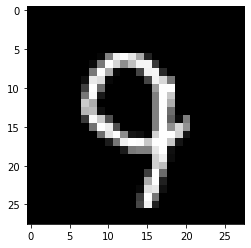

In [190]:
!pip install numpy
!pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
img = np.array(x_test[999], dtype='float')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [191]:
scoring_data = {"input_data": [{"values": [x_test[999].tolist()]}]}
predictions = wml_client.deployments.score(deployment_uid, scoring_data)

In [192]:
json.dumps(scoring_data)

'{"input_data": [{"values": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0

In [193]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "id": "dense_1",
      "fields": [
        "prediction",
        "prediction_classes",
        "probability"
      ],
      "values": [
        [
          [
            0.0863162949681282,
            0.05858057737350464,
            0.08828134089708328,
            0.08890403062105179,
            0.14057880640029907,
            0.07244487851858139,
            0.10328609496355057,
            0.11191179603338242,
            0.09308787435293198,
            0.15660829842090607
          ],
          9,
          [
            0.0863162949681282,
            0.05858057737350464,
            0.08828134089708328,
            0.08890403062105179,
            0.14057880640029907,
            0.07244487851858139,
            0.10328609496355057,
            0.11191179603338242,
            0.09308787435293198,
            0.15660829842090607
          ]
        ]
      ]
    }
  ]
}


In [194]:
wos_client.data_sets.show_records(payload_data_set_id)

,a53d4a248b19bd1a1d0fc79c2ff3210f-1,2021-12-22T23:15:44.873940Z,0.15660829842090607,"[0.0863162949681282, 0.05858057737350464, 0.08828134089708328, 0.08890403062105179, 0.14057880640029907, 0.07244487851858139, 0.10328609496355057, 0.11191179603338242, 0.09308787435293198, 0.15660829842090607]",1a728d58-8e70-42a0-b6ee-63d5f7ef4791,"[0.0863162949681282, 0.05858057737350464, 0.08828134089708328, 0.08890403062105179, 0.14057880640029907, 0.07244487851858139, 0.10328609496355057, 0.11191179603338242, 0.09308787435293198, 0.15660829842090607]",9


## 4. Custom Monitors and Metrics
### Register custom monitor

In [195]:
def get_definition(monitor_name):
    monitor_definitions = wos_client.monitor_definitions.list().result.monitor_definitions
    
    for definition in monitor_definitions:
        if monitor_name == definition.entity.name:
            return definition
    
    return None

In [197]:
monitor_name = 'Pixel Level Metrics'
metrics = [MonitorMetricRequest(name='Pixel Accuracy',
                                thresholds=[MetricThreshold(type=MetricThresholdTypes.LOWER_LIMIT, default=0.8)]),
          MonitorMetricRequest(name='Dice Score',
                                thresholds=[MetricThreshold(type=MetricThresholdTypes.LOWER_LIMIT, default=0.75)]),
          MonitorMetricRequest(name='IoU',
                                thresholds=[MetricThreshold(type=MetricThresholdTypes.LOWER_LIMIT, default=0.6)])]
tags = []#[MonitorTagRequest(name='region', description='customer geographical region')]

existing_definition = get_definition(monitor_name)

if existing_definition is None:
    custom_monitor_details = wos_client.monitor_definitions.add(name=monitor_name, metrics=metrics, tags=tags, background_mode=False).result
else:
    print('monitor found')
    custom_monitor_details = existing_definition



monitor found


In [198]:
wos_client.monitor_definitions.show()

pixel_level_metrics,Pixel Level Metrics,"['Pixel Accuracy', 'Dice Score', 'IoU']"
custom_monitor_test,custom_monitor_test,"['sensitivity', 'specificity']"
assurance,Assurance,"['Uncertainty', 'Confidence']"
fairness,Fairness,"['Fairness value', 'Average Odds Difference metric value', 'False Discovery Rate Difference metric value', 'Error Rate Difference metric value', 'False Negative Rate Difference metric value', 'False Omission Rate Difference metric value', 'False Positive Rate Difference metric value', 'True Positive Rate Difference metric value']"
performance,Performance,['Number of records']
explainability,Explainability,[]
mrm,Model risk management monitoring,"['Tests run', 'Tests passed', 'Tests failed', 'Tests skipped', 'Fairness score', 'Quality score', 'Drift score']"
correlations,Correlations,"['Maximum positive correlation coefficient', 'Maximum negative correlation coefficient', 'Mean absolute correlation coefficient', 'Significant correlation coefficients count']"
drift,Drift,"['Drop in accuracy', 'Predicted accuracy', 'Drop in data consistency']"
quality,Quality,"['Area under ROC', 'Area under PR', 'Proportion explained variance', 'Mean absolute error', 'Mean squared error', 'R squared', 'Root of mean squared error', 'Accuracy', 'Weighted True Positive Rate (wTPR)', 'True positive rate (TPR)', 'Weighted False Positive Rate (wFPR)', 'False positive rate (FPR)', 'Weighted recall', 'Recall', 'Weighted precision', 'Precision', 'Weighted F1-Measure', 'F1-Measure', 'Logarithmic loss']"


In [199]:
custom_monitor_id = custom_monitor_details.metadata.id
print(custom_monitor_id)

pixel_level_metrics


In [200]:
custom_monitor_details = wos_client.monitor_definitions.get(monitor_definition_id=custom_monitor_id).result
print('Monitor definition details:', custom_monitor_details)

Monitor definition details: {
  "metadata": {
    "id": "pixel_level_metrics",
    "crn": "crn:v1:bluemix:public:aiopenscale:us-south:a/na:00000000-0000-0000-0000-000000000000:monitor_definition:pixel_level_metrics",
    "url": "/v2/monitor_definitions/pixel_level_metrics",
    "created_at": "2021-12-22T18:51:48.860000Z",
    "created_by": "wendy"
  },
  "entity": {
    "name": "Pixel Level Metrics",
    "metrics": [
      {
        "name": "Pixel Accuracy",
        "thresholds": [
          {
            "type": "lower_limit",
            "default": 0.8
          }
        ],
        "expected_direction": "increasing",
        "id": "pixel_accuracy"
      },
      {
        "name": "Dice Score",
        "thresholds": [
          {
            "type": "lower_limit",
            "default": 0.75
          }
        ],
        "expected_direction": "increasing",
        "id": "dice_score"
      },
      {
        "name": "IoU",
        "thresholds": [
          {
            "type": "lowe

### Enable custom monitor for subscription

In [201]:
target = Target(
        target_type=TargetTypes.SUBSCRIPTION,
        target_id=subscription_id
    )

thresholds = [MetricThresholdOverride(metric_id='iou', type = MetricThresholdTypes.LOWER_LIMIT, value=0.9)]

custom_monitor_instance_details = wos_client.monitor_instances.create(
            data_mart_id=data_mart_id,
            background_mode=False,
            monitor_definition_id=custom_monitor_id,
            target=target
).result




 Waiting for end of monitor instance creation 6c35350a-a54f-4721-9b92-8f65f3bd9aa9 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [202]:
custom_monitor_instance_id = custom_monitor_instance_details.metadata.id

In [203]:
custom_monitor_instance_details = wos_client.monitor_instances.get(custom_monitor_instance_id).result
print(custom_monitor_instance_details)

{
  "metadata": {
    "id": "6c35350a-a54f-4721-9b92-8f65f3bd9aa9",
    "crn": "crn:v1:bluemix:public:aiopenscale:us-south:a/na:00000000-0000-0000-0000-000000000000:monitor_instance:6c35350a-a54f-4721-9b92-8f65f3bd9aa9",
    "url": "/v2/monitor_instances/6c35350a-a54f-4721-9b92-8f65f3bd9aa9",
    "created_at": "2021-12-22T23:19:23.558000Z",
    "created_by": "wendy"
  },
  "entity": {
    "data_mart_id": "00000000-0000-0000-0000-000000000000",
    "monitor_definition_id": "pixel_level_metrics",
    "target": {
      "target_type": "subscription",
      "target_id": "9c6845ac-5d18-41bf-a205-a7e4f44fad80"
    },
    "thresholds": [
      {
        "metric_id": "pixel_accuracy",
        "type": "lower_limit",
        "value": 0.8
      },
      {
        "metric_id": "dice_score",
        "type": "lower_limit",
        "value": 0.75
      },
      {
        "metric_id": "iou",
        "type": "lower_limit",
        "value": 0.6
      }
    ],
    "status": {
      "state": "active"
    }


### Storing custom metrics

In [204]:
from datetime import datetime, timezone, timedelta
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import MonitorMeasurementRequest
custom_monitoring_run_id = "11122223333111abc"
measurement_request = [MonitorMeasurementRequest(timestamp=datetime.now(timezone.utc), 
                                                 metrics=[{"pixel_accuracy": 0.78, "dice_score": 0.67, 'iou': 0.5}], run_id=custom_monitoring_run_id)]
print(measurement_request[0])

{
  "timestamp": "2021-12-22T23:19:34.310757Z",
  "run_id": "11122223333111abc",
  "metrics": [
    {
      "pixel_accuracy": 0.78,
      "dice_score": 0.67,
      "iou": 0.5
    }
  ]
}


In [205]:
published_measurement_response = wos_client.monitor_instances.measurements.add(
    monitor_instance_id=custom_monitor_instance_id,
    monitor_measurement_request=measurement_request).result
published_measurement_id = published_measurement_response[0]["measurement_id"]
print(published_measurement_response)

[{'measurement_id': '4b95ea86-cbd3-4ce8-a7cd-64160cf34927', 'metrics': [{'dice_score': 0.67, 'iou': 0.5, 'pixel_accuracy': 0.78}], 'run_id': '11122223333111abc', 'timestamp': '2021-12-22T23:19:34.310757Z'}]


In [206]:
import time
time.sleep(5)
published_measurement = wos_client.monitor_instances.measurements.get(monitor_instance_id=custom_monitor_instance_id, measurement_id=published_measurement_id).result
print(published_measurement)

{
  "metadata": {
    "id": "4b95ea86-cbd3-4ce8-a7cd-64160cf34927",
    "crn": "",
    "url": "/v2/monitor_instances/6c35350a-a54f-4721-9b92-8f65f3bd9aa9/measurements/4b95ea86-cbd3-4ce8-a7cd-64160cf34927",
    "created_at": "2021-12-22T23:19:35.662000Z",
    "created_by": ""
  },
  "entity": {
    "timestamp": "2021-12-22T23:19:34.310757Z",
    "run_id": "11122223333111abc",
    "values": [
      {
        "metrics": [
          {
            "id": "pixel_accuracy",
            "value": 0.78,
            "lower_limit": 0.8
          },
          {
            "id": "iou",
            "value": 0.5,
            "lower_limit": 0.6
          },
          {
            "id": "dice_score",
            "value": 0.67,
            "lower_limit": 0.75
          }
        ],
        "tags": []
      }
    ],
    "issue_count": 3,
    "target": {
      "target_type": "subscription",
      "target_id": "9c6845ac-5d18-41bf-a205-a7e4f44fad80"
    },
    "monitor_instance_id": "6c35350a-a54f-4721-9b92